# Lab 4: Testing Notebook

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg
from psycopg.rows import dict_row

## Part 1: Data Importing

In [9]:
import pandas as pd
import psycopg

# Connection details
user = "postgres"
password = "psql-password"
host = "127.0.0.1"
conn_string = f"postgresql://{user}:{password}@{host}:5432/house_price_prediction_service"

with psycopg.connect(conn_string, row_factory=psycopg.rows.dict_row) as conn:
    with conn.cursor(name="fetch_all_cursor") as cur:  # Use server-side cursor
        cur.execute("""
            SELECT 
                id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot,
                floors, waterfront, view, condition, grade, sqft_above, sqft_basement,
                yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15,
                population, high_schools, middle_schools, primary_schools, other_schools,
                unknown_schools, total_schools
            FROM cleaned_home_sale_events;
        """)
        
        rows = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(rows)

# Show how many rows were fetched
print(f"Total rows fetched: {len(df)}")

# Display the dataframe
df.head()

Total rows fetched: 130668


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,sqft_living15,sqft_lot15,population,high_schools,middle_schools,primary_schools,other_schools,unknown_schools,total_schools
0,86427,2025-02-25,507000.0,4,2.5,2730,7649,2.0,0,0,...,-121.882,2730,None,38097,2,1,2,2,0,7
1,86528,2025-02-25,408200.0,3,2.5,1800,5761,2.0,0,0,...,-122.363,1800,None,68619,1,0,3,0,0,4
2,86253,2025-02-25,290000.0,4,1.0,1330,8184,1.5,0,0,...,-122.347,1220,None,133665,3,0,6,0,0,9
3,86426,2025-02-25,320000.0,3,2.5,2680,7757,2.0,0,0,...,-122.346,2430,None,142530,2,2,11,0,0,15
4,86512,2025-02-25,450000.0,2,2.0,1100,3000,1.5,0,0,...,-122.362,1390,None,94095,1,1,5,1,0,8


## Part 2: Creating a Regression Model

Model: Linear Regression
  RMSE: $124352.18
  MAPE: 13.22%
  R-squared: 0.8870


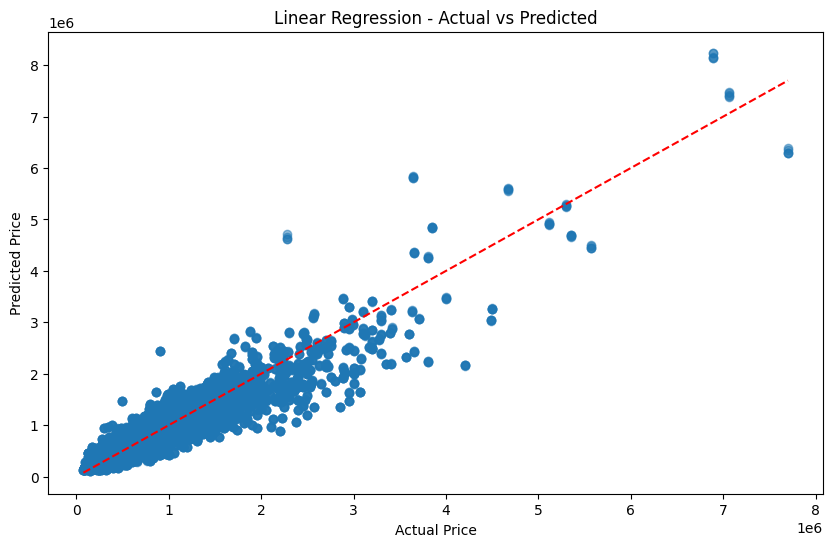

Model: Ridge Regression
  RMSE: $124344.56
  MAPE: 13.23%
  R-squared: 0.8869


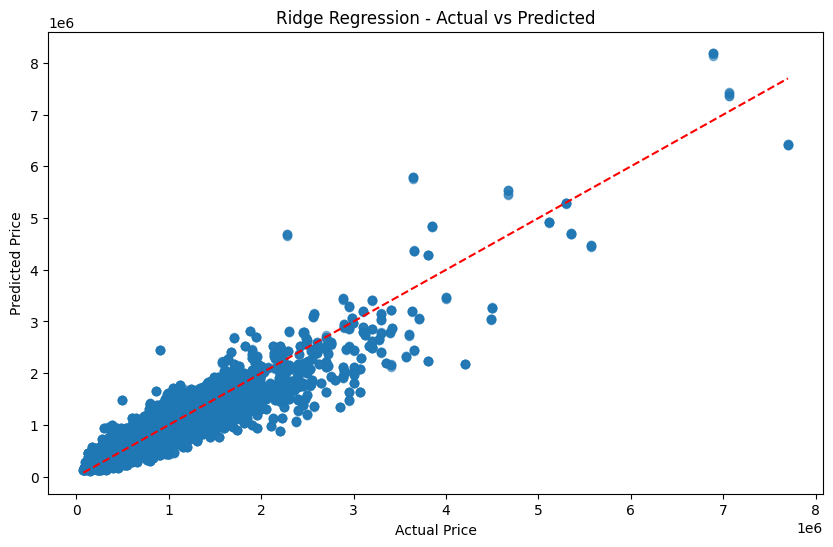

Model: Lasso Regression
  RMSE: $249189.18
  MAPE: 25.13%
  R-squared: 0.6356


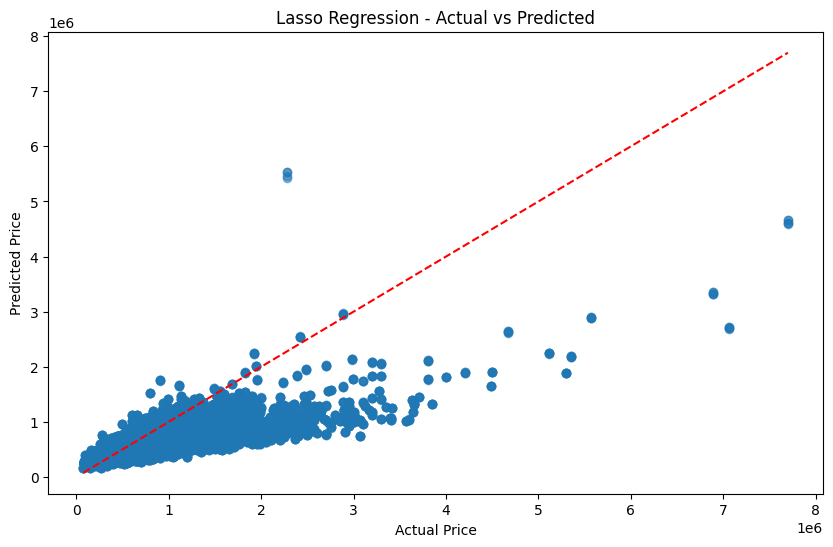

Model: ElasticNet
  RMSE: $220501.03
  MAPE: 21.85%
  R-squared: 0.7201


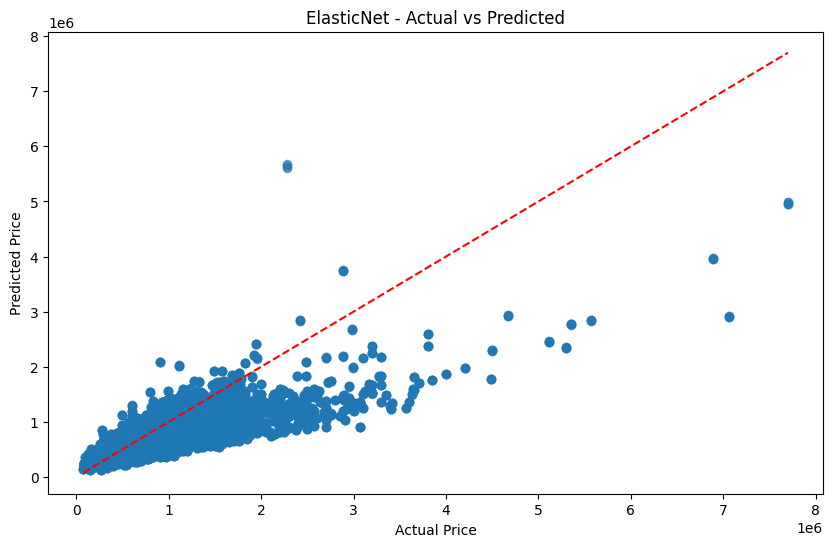

Model: Random Forest
  RMSE: $17214.92
  MAPE: 1.44%
  R-squared: 0.9965


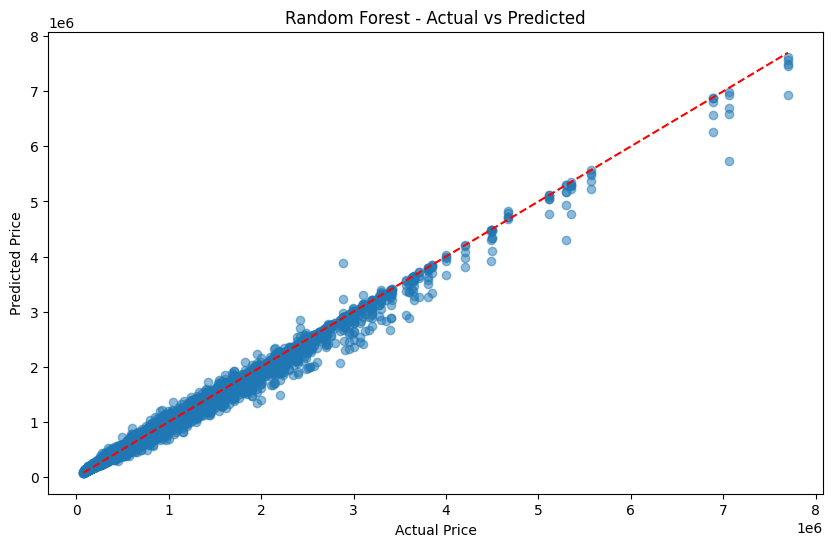

Model: Gradient Boosting
  RMSE: $122814.95
  MAPE: 12.86%
  R-squared: 0.8929


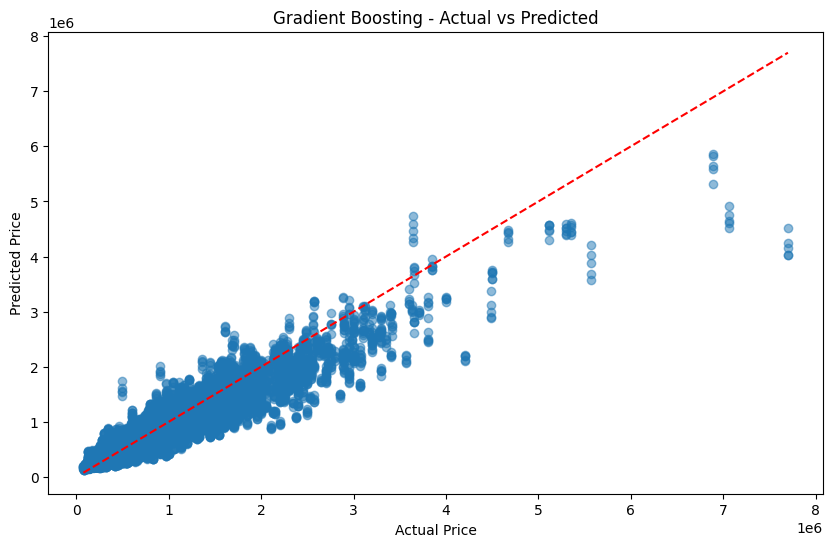

Model: XGBoost
  RMSE: $66960.58
  MAPE: 8.50%
  R-squared: 0.9536


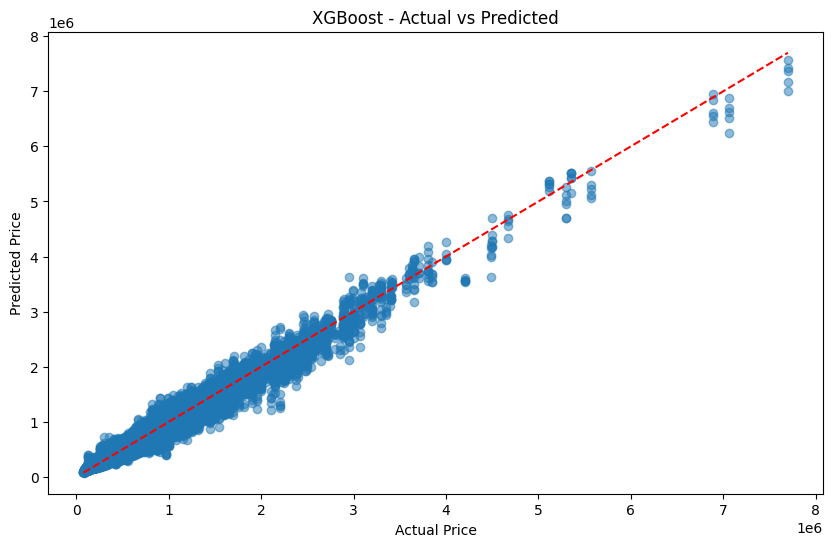


Model Comparison:
                name           rmse       mape        r2
4      Random Forest   17214.916933   1.435565  0.996535
6            XGBoost   66960.581534   8.501280  0.953597
5  Gradient Boosting  122814.954626  12.861993  0.892868
1   Ridge Regression  124344.563780  13.228935  0.886949
0  Linear Regression  124352.182266  13.223788  0.887005
3         ElasticNet  220501.030096  21.854874  0.720134
2   Lasso Regression  249189.180593  25.130322  0.635645


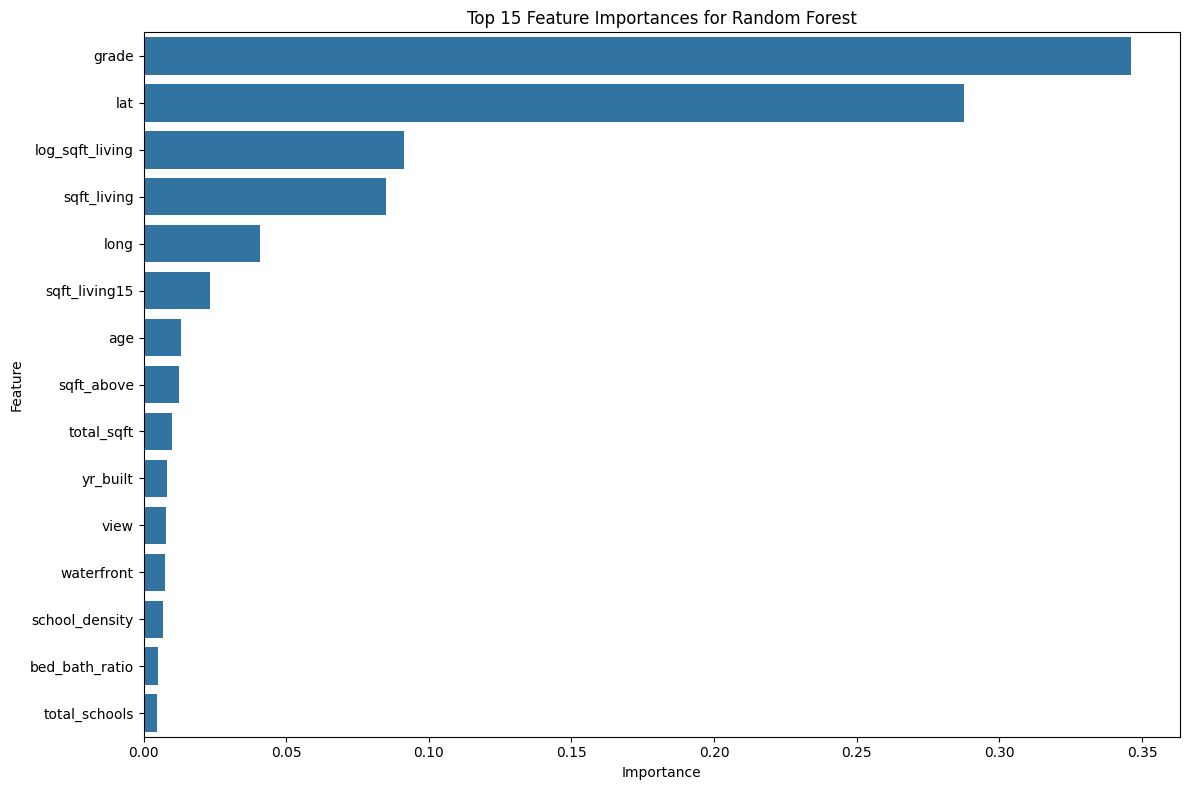


Hyperparameter tuning for Random Forest
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best RMSE: $889.52
Model: Tuned Random Forest
  RMSE: $16711.64
  MAPE: 1.41%
  R-squared: 0.9966


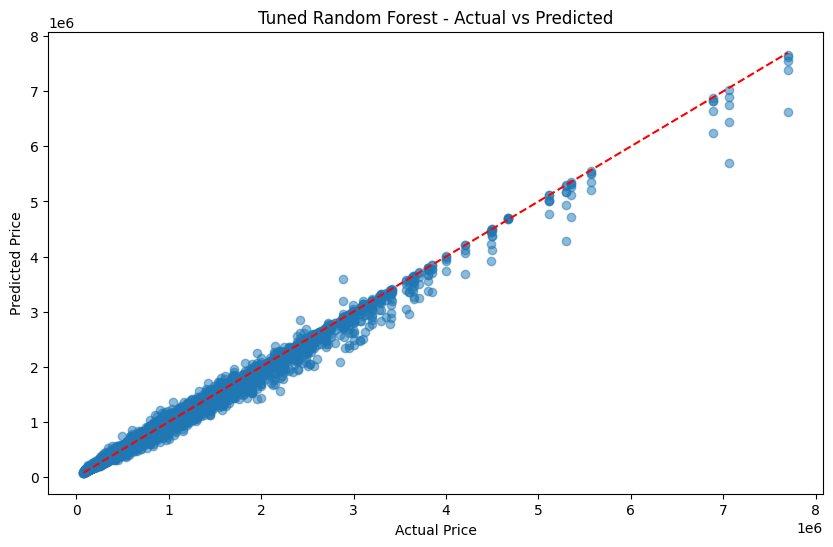


Updated Model Comparison:
                  name           rmse       mape        r2
7  Tuned Random Forest   16711.640677   1.411618  0.996643
4        Random Forest   17214.916933   1.435565  0.996535
6              XGBoost   66960.581534   8.501280  0.953597
5    Gradient Boosting  122814.954626  12.861993  0.892868
1     Ridge Regression  124344.563780  13.228935  0.886949
0    Linear Regression  124352.182266  13.223788  0.887005
3           ElasticNet  220501.030096  21.854874  0.720134
2     Lasso Regression  249189.180593  25.130322  0.635645

Final Selected Model: Tuned Random Forest
RMSE: $16711.64
MAPE: 1.41%
R-squared: 0.9966

Conclusion:
The best model for house price prediction is Tuned Random Forest.
This model achieves an RMSE of $16711.64, 
a MAPE of 1.41%, 
and an R-squared of 0.9966.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation
# Convert date to datetime and extract features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear

# Sort by date to ensure proper time series split
df = df.sort_values('date')

# Handle missing values in sqft_lot15
df['sqft_lot15'] = df['sqft_lot15'].fillna(df['sqft_lot'])

# 2. Feature Engineering
# Create new features
df['age'] = df['year'] - df['yr_built']
df['renovated'] = (df['yr_renovated'] > 0).astype(int)
df['total_sqft'] = df['sqft_living'] + df['sqft_lot']

# Avoid division by zero
df['price_per_sqft'] = np.where(df['sqft_living'] > 0, df['price'] / df['sqft_living'], 0)
df['bed_bath_ratio'] = np.where(df['bathrooms'] > 0, df['bedrooms'] / df['bathrooms'], 0)
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['school_density'] = np.where(df['population'] > 0, df['total_schools'] / df['population'] * 10000, 0)

# Log transform price and some features to normalize distributions - add small constant to avoid log(0)
df['log_price'] = np.log1p(df['price'])
df['log_sqft_living'] = np.log1p(df['sqft_living'])
df['log_sqft_lot'] = np.log1p(df['sqft_lot'])
df['log_population'] = np.log1p(df['population'])

# Create categorical features as needed
df['age_category'] = pd.cut(df['age'], bins=[0, 10, 20, 40, 80, 150], labels=['New', 'Recent', 'Mid', 'Old', 'Very Old'])
df['size_category'] = pd.cut(df['sqft_living'], bins=[0, 1000, 2000, 3000, 5000, 15000], labels=['Tiny', 'Small', 'Medium', 'Large', 'Mansion'])

# 3. Define features and target
# We'll use log_price as our target for better model performance
target = 'log_price'
y = df[target]

# Select features, removing direct price-related columns and the original target
non_features = ['id', 'date', 'price', 'log_price', 'price_per_sqft', 'age_category', 'size_category']
features = [col for col in df.columns if col not in non_features]
X = df[features]

# Replace any infinities or extremely large values
X = X.replace([np.inf, -np.inf], np.nan)

# Feature types for preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 4. Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# 5. Model Evaluation with Time Series Cross-Validation
def evaluate_model(model, X, y, model_name, cv=5):
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Metrics for each fold
    rmse_scores = []
    mape_scores = []
    r2_scores = []
    
    # Track predictions for plotting
    all_y_test = []
    all_y_pred = []
    
    # Perform cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store predictions
        all_y_test.append(y_test)
        all_y_pred.append(y_pred)
        
        # Calculate metrics
        # Convert back from log scale for interpretable RMSE and MAPE
        y_test_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)
        
        rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
        mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100
        r2 = r2_score(y_test, y_pred)  # R² on log scale is more appropriate
        
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
    
    # Average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mape = np.mean(mape_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"Model: {model_name}")
    print(f"  RMSE: ${avg_rmse:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")
    print(f"  R-squared: {avg_r2:.4f}")
    
    # Concatenate all test sets and predictions
    all_y_test = np.concatenate(all_y_test)
    all_y_pred = np.concatenate(all_y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(all_y_test), np.expm1(all_y_pred), alpha=0.5)
    plt.plot([np.expm1(all_y_test).min(), np.expm1(all_y_test).max()], 
             [np.expm1(all_y_test).min(), np.expm1(all_y_test).max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.show()
    
    return {
        'model': model,
        'name': model_name,
        'rmse': avg_rmse,
        'mape': avg_mape,
        'r2': avg_r2
    }

# 6. Define and evaluate models
models = [
    (Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]), 'Linear Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))]), 'Ridge Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))]), 'Lasso Regression'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))]), 'ElasticNet'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]), 'Random Forest'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]), 'Gradient Boosting'),
    (Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))]), 'XGBoost')
]

results = []
for model, name in models:
    result = evaluate_model(model, X, y, name, cv=5)
    results.append(result)

# 7. Compare models
results_df = pd.DataFrame(results)
results_df = results_df[['name', 'rmse', 'mape', 'r2']]
print("\nModel Comparison:")
print(results_df.sort_values('rmse'))

# 8. Feature importance of the best model (assuming it's tree-based)
best_model_idx = results_df['rmse'].idxmin()
best_model = results[best_model_idx]['model']
best_model_name = results[best_model_idx]['name']

# If the best model is tree-based, we can extract feature importance
if 'Forest' in best_model_name or 'Boost' in best_model_name or 'XGB' in best_model_name:
    # Get feature names from preprocessor
    try:
        feature_names = (numeric_features + 
                        list(best_model.named_steps['preprocessor']
                            .named_transformers_['cat']
                            .named_steps['onehot']
                            .get_feature_names_out(categorical_features)))
        
        # Extract importance
        importances = best_model.named_steps['regressor'].feature_importances_
        
        # Create DataFrame for plotting
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'Top 15 Feature Importances for {best_model_name}')
        plt.tight_layout()
        plt.show()
    except:
        print("Could not extract feature importances - model may not support this.")

# 9. Hyperparameter tuning for the best model
print(f"\nHyperparameter tuning for {best_model_name}")

# Define hyperparameter grid based on the best model type
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif 'Boost' in best_model_name:
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
elif best_model_name == 'Ridge Regression':
    param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
elif best_model_name == 'Lasso Regression':
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1.0]}
elif best_model_name == 'ElasticNet':
    param_grid = {
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    }
else:  # Linear Regression or XGBoost
    param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    } if 'XGB' in best_model_name else {}

# Perform grid search if there are hyperparameters to tune
if param_grid:
    tscv = TimeSeriesSplit(n_splits=3)  # Fewer splits for faster tuning
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best RMSE: ${np.sqrt(mean_squared_error(np.expm1(y), np.expm1(grid_search.predict(X)))):.2f}")
    
    # Evaluate the tuned model
    tuned_result = evaluate_model(grid_search.best_estimator_, X, y, f"Tuned {best_model_name}", cv=5)
    results.append(tuned_result)
    
    # Update results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df[['name', 'rmse', 'mape', 'r2']]
    print("\nUpdated Model Comparison:")
    print(results_df.sort_values('rmse'))

# 10. Final evaluation on the entire dataset
final_model_idx = results_df['rmse'].idxmin()
final_model = results[final_model_idx]['model']
final_model_name = results[final_model_idx]['name']

print(f"\nFinal Selected Model: {final_model_name}")
print(f"RMSE: ${results_df.iloc[final_model_idx]['rmse']:.2f}")
print(f"MAPE: {results_df.iloc[final_model_idx]['mape']:.2f}%")
print(f"R-squared: {results_df.iloc[final_model_idx]['r2']:.4f}")

# 11. Conclusion
print("\nConclusion:")
print(f"The best model for house price prediction is {final_model_name}.")
print(f"This model achieves an RMSE of ${results_df.iloc[final_model_idx]['rmse']:.2f}, ")
print(f"a MAPE of {results_df.iloc[final_model_idx]['mape']:.2f}%, ")
print(f"and an R-squared of {results_df.iloc[final_model_idx]['r2']:.4f}.")

## Part 3: SciKit Learn Pipeline

Building and evaluating pipeline...
Pipeline Evaluation Results:
  RMSE: $384792.27
  MAPE: 46.95%
  R-squared: -0.1182


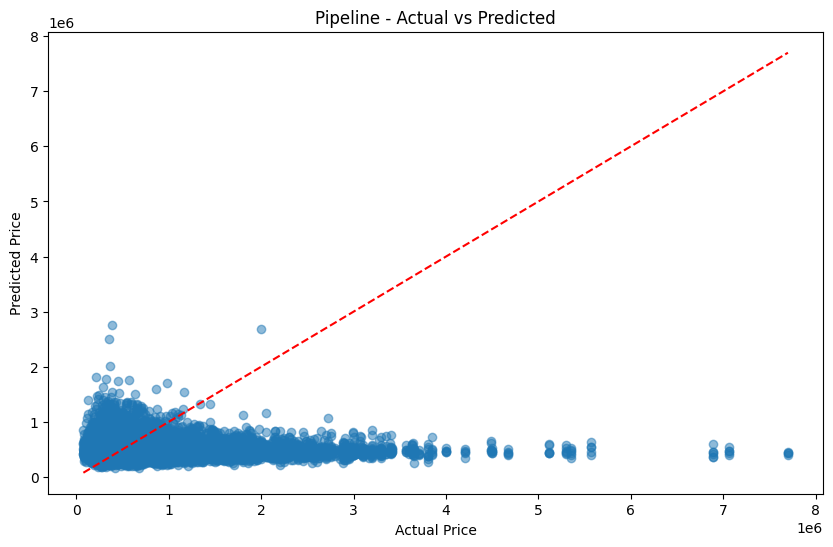


Pipeline Structure:

Feature Importance:


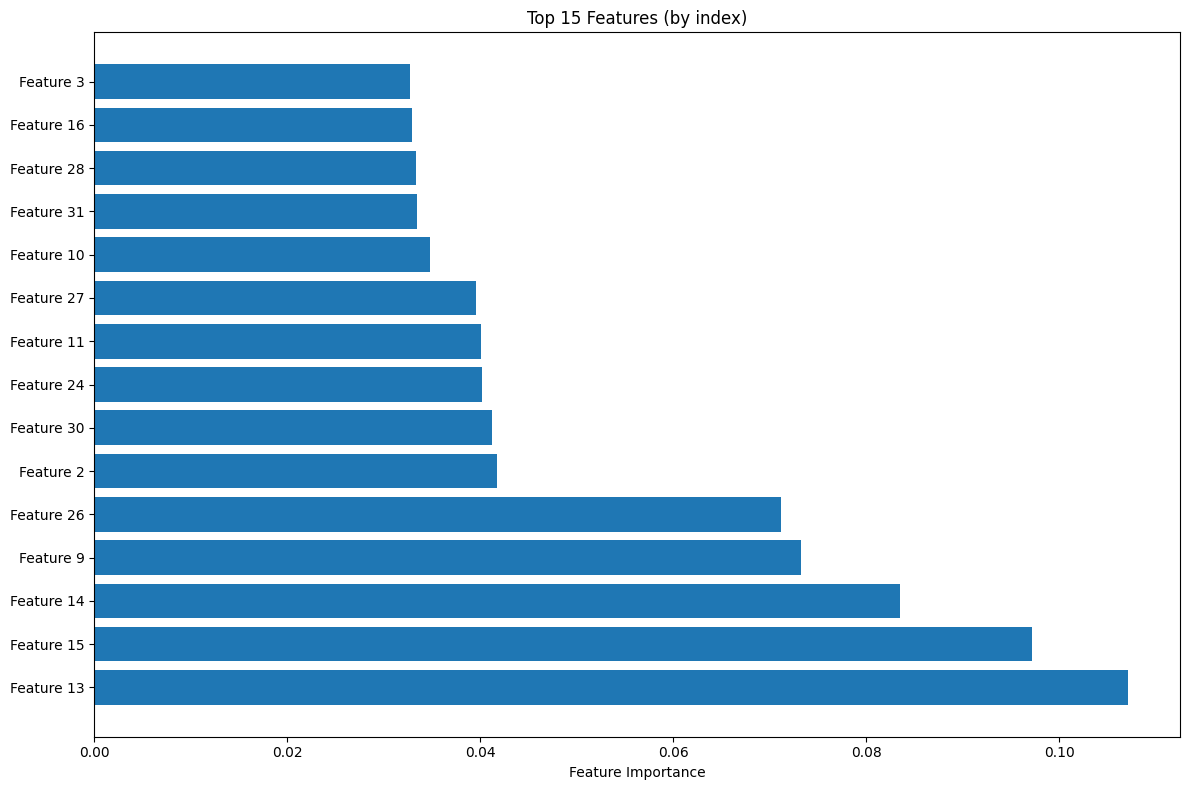


Predicting house price...
Input sample:
bedrooms           2
bathrooms       2.25
sqft_living     1610
zipcode        98056
Name: 125764, dtype: object

Predicted price: $469,877.75

Pipeline Summary:
- RMSE: $384792.27
- MAPE: 46.95%
- R-squared: -0.1182
- Pipeline encapsulates all preprocessing and feature engineering steps
- Pipeline can be saved and reused for new predictions


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# Define custom transformer for feature engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Make a copy to avoid modifying the original
        X_new = X.copy()
        
        # Handle date features
        X_new['date'] = pd.to_datetime(X_new['date'])
        X_new['year'] = X_new['date'].dt.year
        X_new['month'] = X_new['date'].dt.month
        X_new['day_of_week'] = X_new['date'].dt.dayofweek
        X_new['day_of_year'] = X_new['date'].dt.dayofyear
        
        # Handle missing values in sqft_lot15
        X_new['sqft_lot15'] = X_new['sqft_lot15'].fillna(X_new['sqft_lot'])
        
        # Create derived features
        X_new['age'] = X_new['year'] - X_new['yr_built']
        X_new['renovated'] = (X_new['yr_renovated'] > 0).astype(int)
        X_new['total_sqft'] = X_new['sqft_living'] + X_new['sqft_lot']
        
        # Safe division operations
        X_new['price_per_sqft'] = np.where(X_new['sqft_living'] > 0, X_new['price'] / X_new['sqft_living'], 0)
        X_new['bed_bath_ratio'] = np.where(X_new['bathrooms'] > 0, X_new['bedrooms'] / X_new['bathrooms'], 0)
        X_new['total_rooms'] = X_new['bedrooms'] + X_new['bathrooms']
        X_new['school_density'] = np.where(X_new['population'] > 0, X_new['total_schools'] / X_new['population'] * 10000, 0)
        
        # Log transformations
        X_new['log_price'] = np.log1p(X_new['price'])
        X_new['log_sqft_living'] = np.log1p(X_new['sqft_living'])
        X_new['log_sqft_lot'] = np.log1p(X_new['sqft_lot'])
        X_new['log_population'] = np.log1p(X_new['population'])
        
        # Categorical features
        X_new['age_category'] = pd.cut(X_new['age'], 
                                      bins=[0, 10, 20, 40, 80, 150], 
                                      labels=['New', 'Recent', 'Mid', 'Old', 'Very Old'])
        X_new['size_category'] = pd.cut(X_new['sqft_living'], 
                                        bins=[0, 1000, 2000, 3000, 5000, 15000], 
                                        labels=['Tiny', 'Small', 'Medium', 'Large', 'Mansion'])
        
        # Replace any potential infinities
        X_new = X_new.replace([np.inf, -np.inf], np.nan)
        
        return X_new

# Define class for feature selection
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, non_features=None):
        self.non_features = non_features or []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        # Remove non-feature columns
        X_new = X_new.drop(columns=self.non_features, errors='ignore')
        
        # Store the column names for later use
        self.feature_names_ = X_new.columns.tolist()
        self.numeric_features_ = X_new.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features_ = X_new.select_dtypes(include=['object', 'category']).columns.tolist()
        
        return X_new

# Define non-feature columns
non_features = ['id', 'date', 'price', 'log_price', 'price_per_sqft', 'age_category', 'size_category']

# Main function to build and evaluate a complete pipeline
def build_house_price_pipeline(X):
    # First apply feature engineering to determine column types
    fe = FeatureEngineer()
    fs = FeatureSelector(non_features=non_features)
    
    # Transform data to determine feature types
    X_temp = fe.transform(X)
    X_temp = fs.transform(X_temp)
    
    # Get feature types
    numeric_features = X_temp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Build column transformer with determined feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ]
    )
    
    # Build the complete pipeline
    pipeline = Pipeline([
        ('feature_engineer', FeatureEngineer()),  
        ('feature_selector', FeatureSelector(non_features=non_features)),
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=200,
            max_depth=30,
            min_samples_split=2,
            random_state=42
        ))
    ])
    
    return pipeline, numeric_features, categorical_features

# Function to evaluate the pipeline
def evaluate_pipeline(X, target_col='log_price', cv=5):
    # Build pipeline
    pipeline, numeric_features, categorical_features = build_house_price_pipeline(X)
    
    # Create target
    y = np.log1p(X['price'])
    
    # Sort by date for time series split
    X = X.sort_values('date').reset_index(drop=True)
    y = y.reindex(X.index)
    
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Metrics
    rmse_scores = []
    mape_scores = []
    r2_scores = []
    
    # Track predictions for plotting
    all_y_test = []
    all_y_pred = []
    
    # Cross-validation
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Store predictions
        all_y_test.append(y_test)
        all_y_pred.append(y_pred)
        
        # Calculate metrics
        y_test_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)
        
        rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
        mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp) * 100
        r2 = r2_score(y_test, y_pred)
        
        rmse_scores.append(rmse)
        mape_scores.append(mape)
        r2_scores.append(r2)
    
    # Average metrics
    avg_rmse = np.mean(rmse_scores)
    avg_mape = np.mean(mape_scores)
    avg_r2 = np.mean(r2_scores)
    
    print("Pipeline Evaluation Results:")
    print(f"  RMSE: ${avg_rmse:.2f}")
    print(f"  MAPE: {avg_mape:.2f}%")
    print(f"  R-squared: {avg_r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(np.expm1(np.concatenate(all_y_test)), np.expm1(np.concatenate(all_y_pred)), alpha=0.5)
    
    # Add diagonal line
    min_val = min(np.expm1(np.concatenate(all_y_test)).min(), np.expm1(np.concatenate(all_y_pred)).min())
    max_val = max(np.expm1(np.concatenate(all_y_test)).max(), np.expm1(np.concatenate(all_y_pred)).max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Pipeline - Actual vs Predicted')
    plt.show()
    
    # Fit a final model on all data for feature importance
    pipeline.fit(X, y)
    
    return {
        'pipeline': pipeline,
        'rmse': avg_rmse,
        'mape': avg_mape,
        'r2': avg_r2,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }

# Safely plot feature importance with simple index-based approach
def plot_feature_importance(pipeline):
    model = pipeline.named_steps['regressor']
    importances = model.feature_importances_
    
    # Create indices for features (since we can't easily get transformed feature names)
    indices = range(len(importances))
    
    # Sort by importance
    sorted_idx = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [f'Feature {i}' for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Features (by index)')
    plt.tight_layout()
    plt.show()
    
    return sorted_idx, importances[sorted_idx]

# Actually visualize the pipeline
def visualize_pipeline(pipeline):
    from sklearn import set_config
    set_config(display='diagram')
    return pipeline

# Sample prediction function
def predict_house_price(pipeline, sample_data):
    print("\nPredicting house price...")
    print("Input sample:")
    print(sample_data[['bedrooms', 'bathrooms', 'sqft_living', 'zipcode']].iloc[0])
    
    # Make prediction
    pred_log = pipeline.predict(sample_data)
    pred_price = np.expm1(pred_log)
    
    print(f"\nPredicted price: ${pred_price[0]:,.2f}")
    return pred_price[0]

# Run the complete pipeline
print("Building and evaluating pipeline...")
results = evaluate_pipeline(df)

# Visualize the pipeline
print("\nPipeline Structure:")
visualize_pipeline(results['pipeline'])

# Plot feature importance
print("\nFeature Importance:")
top_indices, top_importances = plot_feature_importance(results['pipeline'])

# Try a prediction
sample_house = df.iloc[[0]].copy()
predicted_price = predict_house_price(results['pipeline'], sample_house)

print("\nPipeline Summary:")
print(f"- RMSE: ${results['rmse']:.2f}")
print(f"- MAPE: {results['mape']:.2f}%")
print(f"- R-squared: {results['r2']:.4f}")
print("- Pipeline encapsulates all preprocessing and feature engineering steps")
print("- Pipeline can be saved and reused for new predictions")